In [1]:
%reset
import numpy as np 
import pandas as pd 
import xarray as xr 
import cartopy 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.offsetbox as offsetbox
warnings.filterwarnings("ignore")
#from sklearn_xarray import Stacker, Select

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Shortcut 

[Latest cell](#working_cell)

# Load Data

In [2]:
root_path='/data/keeling/a/rytam2/ccf_model_spread/data/preprocessed/'
kernel_path='/data/keeling/a/rytam2/a/kernels/gcms/'

In [3]:
ts = xr.open_mfdataset(root_path+'ts_hist_CMIP5&6_Y1-150.nc')
eis = xr.open_mfdataset(root_path+'eis_hist_CMIP5&6_Y1-150.nc')
tadv = xr.open_mfdataset(root_path+'tadv_hist_CMIP5&6_Y1-150.nc')*24*3600
rh = xr.open_mfdataset(root_path+'hur_hist_CMIP5&6_Y1-150.nc')
omega = xr.open_mfdataset(root_path+'wap_hist_CMIP5&6_Y1-150.nc')*864
ws = xr.open_mfdataset(root_path+'ws_hist_CMIP5&6_Y1-150.nc')

In [4]:
# Load Kernels 
kernels_list = glob.glob(kernel_path+'*.nc');

dict_sst_kernels = {}
dict_eis_kernels = {}
dict_tadv_kernels = {}
dict_rh_kernels = {}
dict_omega_kernels = {}
dict_ws_kernels = {}

modelname_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl',
                'mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm'] #order must be sticktly followed to match kernels_list


# Get dRdxi from files
for filename in kernels_list:
    kernel=xr.open_mfdataset(filename)
    j = kernels_list.index(filename)
    modelname=modelname_list[j]
    dict_sst_kernels["%s"%modelname] = kernel.isel(i=0).dRdxi
    dict_eis_kernels["%s"%modelname] = kernel.isel(i=1).dRdxi
    dict_tadv_kernels["%s"%modelname] = kernel.isel(i=2).dRdxi
    dict_rh_kernels["%s"%modelname] = kernel.isel(i=3).dRdxi
    dict_omega_kernels["%s"%modelname] = kernel.isel(i=4).dRdxi
    dict_ws_kernels["%s"%modelname] = kernel.isel(i=5).dRdxi
    
# Define new coords 
coords = {'lat':(['latitude'],kernel.lat.values),
         'lon':(['longitude'],kernel.lon.values)}

# Create kernel xarray variables 
sst_kernels = xr.Dataset(data_vars=dict_sst_kernels,coords=coords);
eis_kernels = xr.Dataset(data_vars=dict_eis_kernels,coords=coords);
tadv_kernels = xr.Dataset(data_vars=dict_tadv_kernels,coords=coords);
rh_kernels = xr.Dataset(data_vars=dict_rh_kernels,coords=coords);
omega_kernels = xr.Dataset(data_vars=dict_omega_kernels,coords=coords);
ws_kernels = xr.Dataset(data_vars=dict_ws_kernels,coords=coords);

# Rename to avoid duplicate dimensions
sst_kernels = sst_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
eis_kernels = eis_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
tadv_kernels = tadv_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
rh_kernels = rh_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
omega_kernels = omega_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
ws_kernels = ws_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});

# Remove Seasonality

In [5]:
# Remove seasonal cycle from measurements 
def remove_seasonality(x):
    return x - x.mean(dim='time')

# Group data by month and remove seasonality
ts_noseason = ts.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason = eis.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason = tadv.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason = rh.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason = omega.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason = ws.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 

## Regression Coefficient $\beta$ and $\hat{dX_{i}}$ at all location

In [6]:
# Remove seasonal cycle from measurements 
def approx_change(x,degree):
    if degree == 1: 
        poly=x.polyfit(dim='time', deg=1)
        fit = xr.polyval(x['time'],poly.polyfit_coefficients)
        change = fit.isel(time=-1)-fit.isel(time=0)
        return change
    
def normalize(x): 
    glob = x.mean('lat').mean('lon')
    norm = x/glob
    return x

def ensemble_mean(x):
    return x.to_array(dim='models').mean('models')

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return

In [7]:
# Get approximated change in CCF across period 

# Fast response
da_list=[approx_change(ts_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dSST_hat_fast = xr.merge(da_list)
da_list=[approx_change(eis_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dEIS_hat_fast = xr.merge(da_list)
da_list=[approx_change(tadv_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dTadv_hat_fast = xr.merge(da_list)
da_list=[approx_change(rh_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dRH_hat_fast = xr.merge(da_list)
da_list=[approx_change(omega_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dOmega_hat_fast = xr.merge(da_list)
da_list=[approx_change(ws_noseason[var].isel(time=slice(0,239+2)),1).rename(var) for var in modelname_list]
dWS_hat_fast = xr.merge(da_list)

# Slow response
da_list=[approx_change(ts_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dSST_hat_slow = xr.merge(da_list)
da_list=[approx_change(eis_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dEIS_hat_slow = xr.merge(da_list)
da_list=[approx_change(tadv_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dTadv_hat_slow = xr.merge(da_list)
da_list=[approx_change(rh_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dRH_hat_slow = xr.merge(da_list)
da_list=[approx_change(omega_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dOmega_hat_slow = xr.merge(da_list)
da_list=[approx_change(ws_noseason[var].isel(time=slice(241,-1)),1).rename(var) for var in modelname_list]
dWS_hat_slow = xr.merge(da_list)

In [8]:
dSST_hat_fast_bar = ensemble_mean(dSST_hat_fast)
dEIS_hat_fast_bar = ensemble_mean(dEIS_hat_fast)
dTadv_hat_fast_bar = ensemble_mean(dTadv_hat_fast)
dRH_hat_fast_bar = ensemble_mean(dRH_hat_fast)
dOmega_hat_fast_bar = ensemble_mean(dOmega_hat_fast)
dWS_hat_fast_bar = ensemble_mean(dWS_hat_fast)

dSST_hat_slow_bar = ensemble_mean(dSST_hat_slow)
dEIS_hat_slow_bar = ensemble_mean(dEIS_hat_slow)
dTadv_hat_slow_bar = ensemble_mean(dTadv_hat_slow)
dRH_hat_slow_bar = ensemble_mean(dRH_hat_slow)
dOmega_hat_slow_bar = ensemble_mean(dOmega_hat_slow)
dWS_hat_slow_bar = ensemble_mean(dWS_hat_slow)

dSST_hat_fast_norm = normalize(dSST_hat_fast)
dSST_hat_slow_norm = normalize(dSST_hat_slow)
dSST_hat_fast_norm_bar = ensemble_mean(dSST_hat_fast_norm)
dSST_hat_slow_norm_bar = ensemble_mean(dSST_hat_slow_norm)

dEIS_hat_fast_norm = normalize(dEIS_hat_fast)
dEIS_hat_slow_norm = normalize(dEIS_hat_slow)
dEIS_hat_fast_norm_bar = ensemble_mean(dEIS_hat_fast_norm)
dEIS_hat_slow_norm_bar = ensemble_mean(dEIS_hat_slow_norm)

dTadv_hat_fast_norm = normalize(dTadv_hat_fast)
dTadv_hat_slow_norm = normalize(dTadv_hat_slow)
dTadv_hat_fast_norm_bar = ensemble_mean(dTadv_hat_fast_norm)
dTadv_hat_slow_norm_bar = ensemble_mean(dTadv_hat_slow_norm)

dRH_hat_fast_norm = normalize(dRH_hat_fast)
dRH_hat_slow_norm = normalize(dRH_hat_slow)
dRH_hat_fast_norm_bar = ensemble_mean(dRH_hat_fast_norm)
dRH_hat_slow_norm_bar = ensemble_mean(dRH_hat_slow_norm)

dOmega_hat_fast_norm = normalize(dOmega_hat_fast)
dOmega_hat_slow_norm = normalize(dOmega_hat_slow)
dOmega_hat_fast_norm_bar = ensemble_mean(dOmega_hat_fast_norm)
dOmega_hat_slow_norm_bar = ensemble_mean(dOmega_hat_slow_norm)

dWS_hat_fast_norm = normalize(dWS_hat_fast)
dWS_hat_slow_norm = normalize(dWS_hat_slow)
dWS_hat_fast_norm_bar = ensemble_mean(dWS_hat_fast_norm)
dWS_hat_slow_norm_bar = ensemble_mean(dWS_hat_slow_norm)

## $dR_{ij}$ (per CCF, per ensemble member, normalized with global change of dCCF)

In [9]:
dR_SST_hat_fast = dSST_hat_fast * sst_kernels
dR_EIS_hat_fast = dEIS_hat_fast * eis_kernels
dR_Tadv_hat_fast = dTadv_hat_fast * tadv_kernels
dR_RH_hat_fast = dRH_hat_fast * rh_kernels
dR_Omega_hat_fast = dOmega_hat_fast * omega_kernels
dR_WS_hat_fast = dWS_hat_fast * ws_kernels

dR_SST_hat_slow = dSST_hat_slow * sst_kernels
dR_EIS_hat_slow = dEIS_hat_slow * eis_kernels
dR_Tadv_hat_slow = dTadv_hat_slow * tadv_kernels
dR_RH_hat_slow = dRH_hat_slow * rh_kernels
dR_Omega_hat_slow = dOmega_hat_slow * omega_kernels
dR_WS_hat_slow = dWS_hat_slow * ws_kernels

dR_SST_hat_fast_bar = ensemble_mean(dR_SST_hat_fast)
dR_EIS_hat_fast_bar = ensemble_mean(dR_EIS_hat_fast)
dR_Tadv_hat_fast_bar = ensemble_mean(dR_Tadv_hat_fast)
dR_RH_hat_fast_bar = ensemble_mean(dR_RH_hat_fast)
dR_Omega_hat_fast_bar = ensemble_mean(dR_Omega_hat_fast)
dR_WS_hat_fast_bar = ensemble_mean(dR_WS_hat_fast)

dR_SST_hat_slow_bar = ensemble_mean(dR_SST_hat_slow)
dR_EIS_hat_slow_bar = ensemble_mean(dR_EIS_hat_slow)
dR_Tadv_hat_slow_bar = ensemble_mean(dR_Tadv_hat_slow)
dR_RH_hat_slow_bar = ensemble_mean(dR_RH_hat_slow)
dR_Omega_hat_slow_bar = ensemble_mean(dR_Omega_hat_slow)
dR_WS_hat_slow_bar = ensemble_mean(dR_WS_hat_slow)

## $dR$ (sum of all CCFs per ensemble member) 

In [10]:
dR_hat_fast = dR_SST_hat_fast + dR_EIS_hat_fast + dR_Tadv_hat_fast + dR_RH_hat_fast + dR_Omega_hat_fast + dR_WS_hat_fast
dR_hat_slow = dR_SST_hat_slow + dR_EIS_hat_slow + dR_Tadv_hat_slow + dR_RH_hat_slow + dR_Omega_hat_slow + dR_WS_hat_slow

# Total approximated change in CCF across period Y1-20 and Y21-150

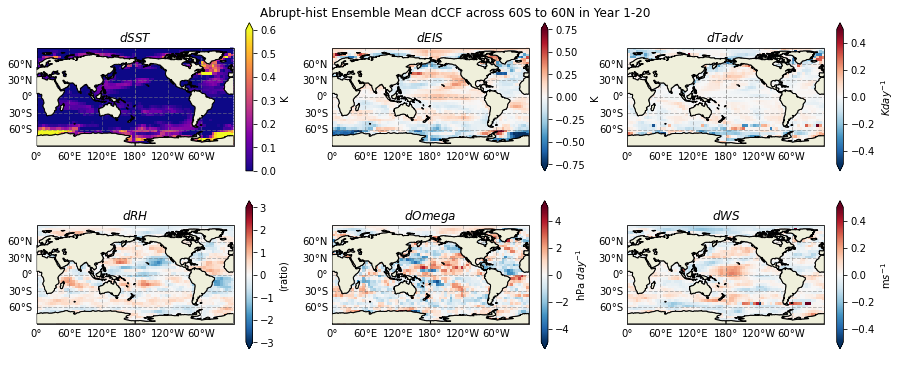

In [16]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dSST_hat_fast_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',cbar_kwargs=dict(label='K'),vmax=0.6,vmin=0, extend='max',)
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
im = dEIS_hat_fast_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=.75,vmin=-.75, extend='both', cbar_kwargs=dict(label='K'))
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dTadv_hat_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r',vmax=0.5,vmin=-.5,extend='both',cbar_kwargs=dict(label='$K day^{-1}$'))
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dRH_hat_fast_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=3,vmin=-3,extend='both',cbar_kwargs=dict(label='(ratio)'))
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dOmega_hat_fast_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both', vmax=5,vmin=-5,cbar_kwargs=dict(label='hPa $day^{-1}$'))
ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dWS_hat_fast_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r', extend='both', vmax=.5,vmin=-.5,cbar_kwargs=dict(label='m$s^{-1}$'))
ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
#fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Abrupt-hist Ensemble Mean dCCF across 60S to 60N in Year 1-20')
ax1.set_title('$dSST$')
ax2.set_title('$dEIS$')
ax3.set_title('$dTadv$')
ax4.set_title('$dRH$')
ax5.set_title('$dOmega$')
ax6.set_title('$dWS$')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dCCF_fast_bar_across_all_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

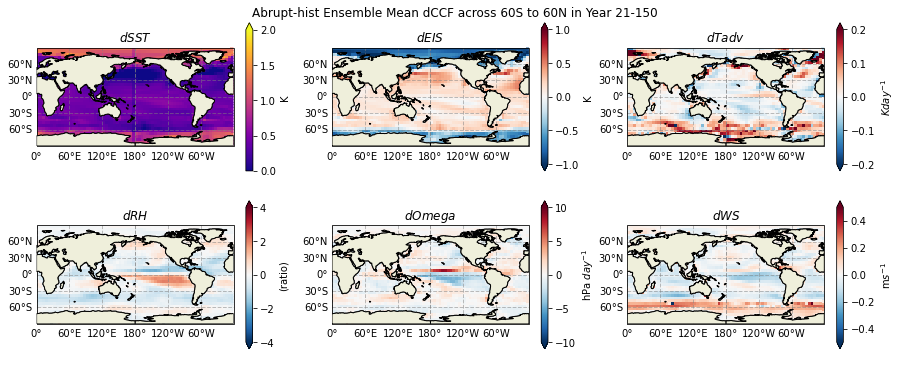

In [15]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dSST_hat_slow_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',cbar_kwargs=dict(label='K'),vmax=2,vmin=0, extend='max',)
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
im = dEIS_hat_slow_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=1,vmin=-1, extend='both', cbar_kwargs=dict(label='K'))
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dTadv_hat_slow_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r',vmax=0.2,vmin=-.2,extend='both',cbar_kwargs=dict(label='$K day^{-1}$'))
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dRH_hat_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=4,vmin=-4,extend='both',cbar_kwargs=dict(label='(ratio)'))
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dOmega_hat_slow_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both', vmax=10,vmin=-10,cbar_kwargs=dict(label='hPa $day^{-1}$'))
ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dWS_hat_slow_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r', extend='both', cbar_kwargs=dict(label='m$s^{-1}$'),vmax=.5,vmin=-.5)
ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
#fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Abrupt-hist Ensemble Mean dCCF across 60S to 60N in Year 21-150')
ax1.set_title('$dSST$')
ax2.set_title('$dEIS$')
ax3.set_title('$dTadv$')
ax4.set_title('$dRH$')
ax5.set_title('$dOmega$')
ax6.set_title('$dWS$')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dCCF_slow_bar_across_all_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

# Calculate contributions of CCFs to dR' 

##  $\hat{dR_{i}}$ SD across models (calculated with approximated $dX_{i}$ (i.e. $\hat{dX_{i}}$))

In [11]:
std_dR_SST_hat_fast = dR_SST_hat_fast.to_array(dim='models').std('models')
std_dR_EIS_hat_fast = dR_EIS_hat_fast.to_array(dim='models').std('models')
std_dR_Tadv_hat_fast = dR_Tadv_hat_fast.to_array(dim='models').std('models')
std_dR_RH_hat_fast = dR_RH_hat_fast.to_array(dim='models').std('models')
std_dR_Omega_hat_fast = dR_Omega_hat_fast.to_array(dim='models').std('models')
std_dR_WS_hat_fast = dR_WS_hat_fast.to_array(dim='models').std('models')
std_dR_hat_fast = dR_hat_fast.to_array(dim='models').std('models')


std_dR_SST_hat_slow = dR_SST_hat_slow.to_array(dim='models').std('models')
std_dR_EIS_hat_slow = dR_EIS_hat_slow.to_array(dim='models').std('models')
std_dR_Tadv_hat_slow = dR_Tadv_hat_slow.to_array(dim='models').std('models')
std_dR_RH_hat_slow = dR_RH_hat_slow.to_array(dim='models').std('models')
std_dR_Omega_hat_slow = dR_Omega_hat_slow.to_array(dim='models').std('models')
std_dR_WS_hat_slow = dR_WS_hat_slow.to_array(dim='models').std('models')
std_dR_hat_slow = dR_hat_slow.to_array(dim='models').std('models')

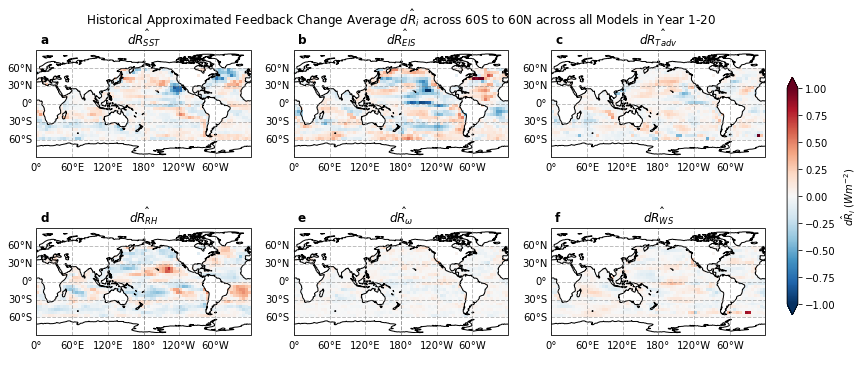

In [12]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

im = dR_SST_hat_fast_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')
dR_EIS_hat_fast_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')
dR_Tadv_hat_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')
dR_RH_hat_fast_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')
dR_Omega_hat_fast_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')
dR_WS_hat_fast_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False, extend='both')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',extend='both')


ax.set_title('Historical Approximated Feedback Change Average $\hat{dR_{i}}$ across 60S to 60N across all Models in Year 1-20')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dRi_hat_fast_bar_across_models_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

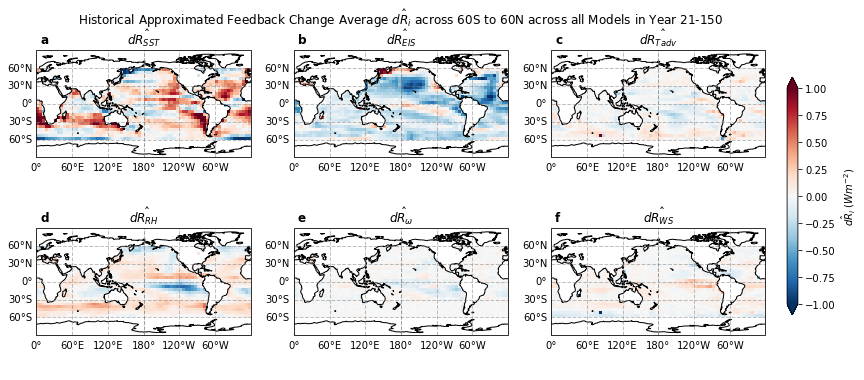

In [13]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dR_SST_hat_slow_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)
im = dR_EIS_hat_slow_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)
dR_Tadv_hat_slow_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)
dR_RH_hat_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)
dR_Omega_hat_slow_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)
dR_WS_hat_slow_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False, extend='both', vmax=1,vmin=-1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',extend='both')


ax.set_title('Historical Approximated Feedback Change Average $\hat{dR_{i}}$ across 60S to 60N across all Models in Year 21-150')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dRi_hat_slow_bar_across_models_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

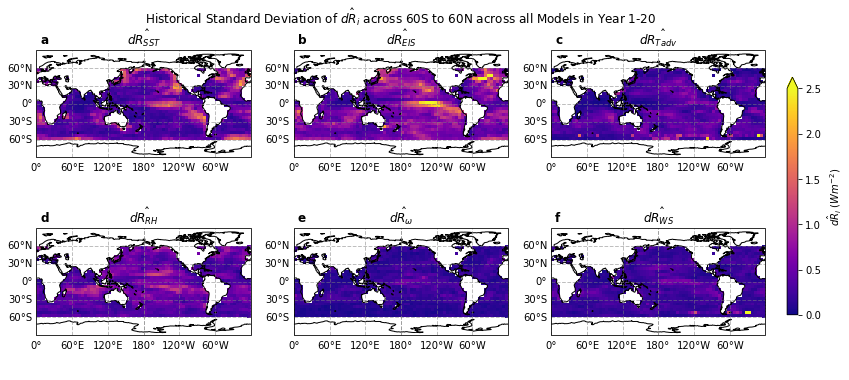

In [20]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

im = std_dR_SST_hat_fast.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_EIS_hat_fast.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_Tadv_hat_fast.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)
std_dR_RH_hat_fast.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_Omega_hat_fast.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)
std_dR_WS_hat_fast.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',ticks=np.arange(0,3,.5),extend='max')


ax.set_title('Historical Standard Deviation of $\hat{dR_{i}}$ across 60S to 60N across all Models in Year 1-20')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_dRi_hat_fast_across_models_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

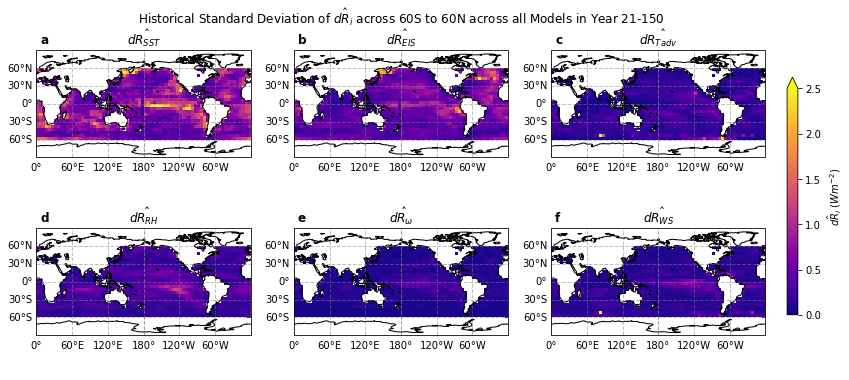

In [21]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

im = std_dR_SST_hat_slow.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_EIS_hat_slow.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_Tadv_hat_slow.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)
std_dR_RH_hat_slow.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=2.5,vmin=0)
std_dR_Omega_hat_slow.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)
std_dR_WS_hat_slow.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=2.5,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$\hat{dR_{i}}$ ($Wm^{-2}$)',ticks=np.arange(0,3,.5),extend='max')


ax.set_title('Historical Standard Deviation of $\hat{dR_{i}}$ across 60S to 60N across all Models in Year 21-150')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_dRi_hat_slow_across_models_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

# Uncertainty Analysis 

In [22]:
# Model Averaged values 
dSST_fast_bar = dSST_hat_fast.to_array('models').mean('models')
dEIS_fast_bar = dEIS_hat_fast.to_array('models').mean('models')
dTadv_fast_bar = dTadv_hat_fast.to_array('models').mean('models')
dRH_fast_bar = dRH_hat_fast.to_array('models').mean('models')
dOmega_fast_bar = dOmega_hat_fast.to_array('models').mean('models')
dWS_fast_bar = dWS_hat_fast.to_array('models').mean('models')
#Model deviations 
dEIS_fast_prime = dEIS_hat_fast - dEIS_fast_bar
dTadv_fast_prime = dTadv_hat_fast - dTadv_fast_bar
dRH_fast_prime = dRH_hat_fast - dRH_fast_bar
dOmega_fast_prime = dOmega_hat_fast - dOmega_fast_bar
dWS_fast_prime = dWS_hat_fast - dWS_fast_bar



# Model Averaged values 
dSST_slow_bar = dSST_hat_slow.to_array('models').mean('models')
dEIS_slow_bar = dEIS_hat_slow.to_array('models').mean('models')
dTadv_slow_bar = dTadv_hat_slow.to_array('models').mean('models')
dRH_slow_bar = dRH_hat_slow.to_array('models').mean('models')
dOmega_slow_bar = dOmega_hat_slow.to_array('models').mean('models')
dWS_slow_bar = dWS_hat_slow.to_array('models').mean('models')
#Model deviations 
dEIS_slow_prime = dEIS_hat_slow - dEIS_slow_bar
dTadv_slow_prime = dTadv_hat_slow - dTadv_slow_bar
dRH_slow_prime = dRH_hat_slow - dRH_slow_bar
dOmega_slow_prime = dOmega_hat_slow - dOmega_slow_bar
dWS_slow_prime = dWS_hat_slow - dWS_slow_bar



sst_kernels_bar = sst_kernels.to_array('models').mean('models')
eis_kernels_bar = eis_kernels.to_array('models').mean('models')
tadv_kernels_bar = tadv_kernels.to_array('models').mean('models')
rh_kernels_bar = rh_kernels.to_array('models').mean('models')
omega_kernels_bar = omega_kernels.to_array('models').mean('models')
ws_kernels_bar = ws_kernels.to_array('models').mean('models')
# kernel deviation from mean 
sst_kernels_prime = sst_kernels-sst_kernels_bar
eis_kernels_prime = eis_kernels-eis_kernels_bar
tadv_kernels_prime = tadv_kernels-tadv_kernels_bar
rh_kernels_prime = rh_kernels-rh_kernels_bar
omega_kernels_prime = omega_kernels-omega_kernels_bar
ws_kernels_prime = ws_kernels-ws_kernels_bar

## Assumption of dR = dX_bar* kernel_prime + dX_prime*kernel_bar Test

In [30]:
# Model SST Sensitivity
dR_model_to_sst_prime_fast = sst_kernels_prime*dSST_fast_bar
dR_model_to_sst_prime_fast_var = dR_model_to_sst_prime_fast.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_fast = (eis_kernels_bar*dEIS_fast_prime)
dR_intrin_eis_prime_fast_var = dR_intrin_eis_prime_fast.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_fast = (eis_kernels_prime*dEIS_fast_bar)
dR_model_to_eis_prime_fast_var = dR_model_to_eis_prime_fast.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_fast = (tadv_kernels_bar*dTadv_fast_prime)
dR_intrin_tadv_prime_fast_var = dR_intrin_tadv_prime_fast.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_fast = (tadv_kernels_prime*dTadv_fast_bar)
dR_model_to_tadv_prime_fast_var = dR_model_to_tadv_prime_fast.to_array(dim='models').var('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_fast = (rh_kernels_bar*dRH_fast_prime)
dR_intrin_rh_prime_fast_var = dR_intrin_rh_prime_fast.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_fast = (rh_kernels_prime*dRH_fast_bar)
dR_model_to_rh_prime_fast_var = dR_model_to_rh_prime_fast.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_fast = (omega_kernels_bar*dOmega_fast_prime)
dR_intrin_omega_prime_fast_var = dR_intrin_omega_prime_fast.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_fast = (omega_kernels_prime*dOmega_fast_bar)
dR_model_to_omega_prime_fast_var = dR_model_to_omega_prime_fast.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_fast = (ws_kernels_bar*dWS_fast_prime)
dR_intrin_ws_prime_fast_var = dR_intrin_ws_prime_fast.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_fast = (ws_kernels_prime*dWS_fast_bar)
dR_model_to_ws_prime_fast_var = dR_model_to_ws_prime_fast.to_array(dim='models').var('models')

dR_intrin_var_fast = dR_intrin_eis_prime_fast_var+dR_intrin_tadv_prime_fast_var+dR_intrin_rh_prime_fast_var+dR_intrin_omega_prime_fast_var+dR_intrin_ws_prime_fast_var
dR_sensitivity_var_fast = dR_model_to_sst_prime_fast_var+dR_model_to_eis_prime_fast_var+dR_model_to_tadv_prime_fast_var+dR_model_to_rh_prime_fast_var+dR_model_to_omega_prime_fast_var+dR_model_to_ws_prime_fast_var
dR_hat_fast_var = dR_hat_fast.to_array('models').var('models')
var_ratio_fast = (dR_intrin_var_fast+dR_sensitivity_var_fast)/dR_hat_fast_var
var_diff_fast = dR_hat_fast_var-(dR_intrin_var_fast+dR_sensitivity_var_fast)

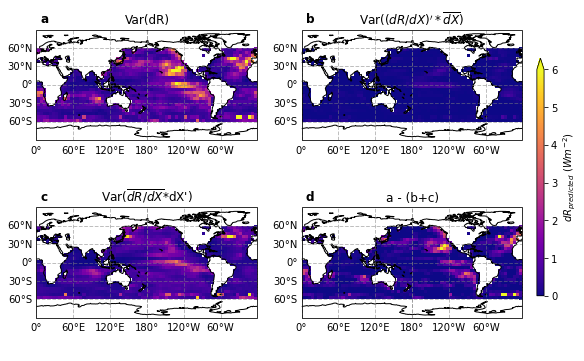

In [38]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im = dR_hat_fast_var.plot(ax=ax1,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmin=0,vmax =6,)
dR_sensitivity_var_fast.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmin=0,vmax=6,)
dR_intrin_var_fast.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmin=0,vmax=6,)
var_diff_fast.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,extend='max', vmin=0, vmax=6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/var_dR_fast_sensitivity_intrin_diff_4maps_hist_cartopy.png', dpi=300,bbox_inches='tight')

In [32]:
# Model SST Sensitivity
dR_model_to_sst_prime_slow = sst_kernels_prime*dSST_slow_bar
dR_model_to_sst_prime_slow_var = dR_model_to_sst_prime_slow.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_slow = (eis_kernels_bar*dEIS_slow_prime)
dR_intrin_eis_prime_slow_var = dR_intrin_eis_prime_slow.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_slow = (eis_kernels_prime*dEIS_slow_bar)
dR_model_to_eis_prime_slow_var = dR_model_to_eis_prime_slow.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_slow = (tadv_kernels_bar*dTadv_slow_prime)
dR_intrin_tadv_prime_slow_var = dR_intrin_tadv_prime_slow.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_slow = (tadv_kernels_prime*dTadv_slow_bar)
dR_model_to_tadv_prime_slow_var = dR_model_to_tadv_prime_slow.to_array(dim='models').var('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_slow = (rh_kernels_bar*dRH_slow_prime)
dR_intrin_rh_prime_slow_var = dR_intrin_rh_prime_slow.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_slow = (rh_kernels_prime*dRH_slow_bar)
dR_model_to_rh_prime_slow_var = dR_model_to_rh_prime_slow.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_slow = (omega_kernels_bar*dOmega_slow_prime)
dR_intrin_omega_prime_slow_var = dR_intrin_omega_prime_slow.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_slow = (omega_kernels_prime*dOmega_slow_bar)
dR_model_to_omega_prime_slow_var = dR_model_to_omega_prime_slow.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_slow = (ws_kernels_bar*dWS_slow_prime)
dR_intrin_ws_prime_slow_var = dR_intrin_ws_prime_slow.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_slow = (ws_kernels_prime*dWS_slow_bar)
dR_model_to_ws_prime_slow_var = dR_model_to_ws_prime_slow.to_array(dim='models').var('models')

dR_intrin_var_slow = dR_intrin_eis_prime_slow_var+dR_intrin_tadv_prime_slow_var+dR_intrin_rh_prime_slow_var+dR_intrin_omega_prime_slow_var+dR_intrin_ws_prime_slow_var
dR_sensitivity_var_slow = dR_model_to_sst_prime_slow_var+dR_model_to_eis_prime_slow_var+dR_model_to_tadv_prime_slow_var+dR_model_to_rh_prime_slow_var+dR_model_to_omega_prime_slow_var+dR_model_to_ws_prime_slow_var
dR_hat_slow_var = dR_hat_slow.to_array('models').var('models')
var_ratio_slow = (dR_intrin_var_slow+dR_sensitivity_var_slow)/dR_hat_slow_var
var_diff_slow = dR_hat_slow_var-(dR_intrin_var_slow+dR_sensitivity_var_slow)

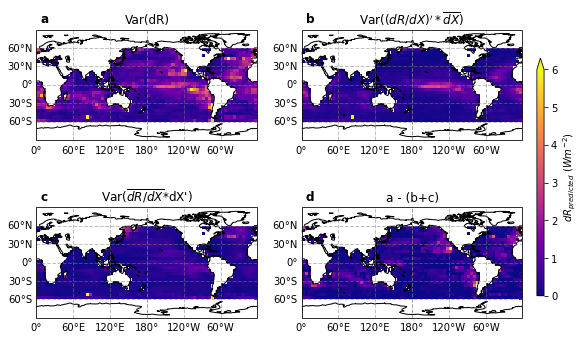

In [39]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im = dR_hat_slow_var.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmin=0,vmax =6)
dR_sensitivity_var_slow.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmin=0,vmax=6,)
dR_intrin_var_slow.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmin=0,vmax=6)
var_diff_slow.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma',extend='max', vmax=6,vmin=0,add_colorbar=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/var_dR_slow_sensitivity_intrin_diff_4maps_hist_cartopy.png', dpi=300,bbox_inches='tight')

## Standard Deviation for all terms

In [34]:
# Model SST Sensitivity
dR_model_to_sst_prime_fast_std = dR_model_to_sst_prime_fast.to_array(dim='models').std('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_fast_std = dR_intrin_eis_prime_fast.to_array(dim='models').std('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_fast_std = dR_model_to_eis_prime_fast.to_array(dim='models').std('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_fast_std = dR_intrin_tadv_prime_fast.to_array(dim='models').std('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_fast_std = dR_model_to_tadv_prime_fast.to_array(dim='models').std('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_fast_std = dR_intrin_rh_prime_fast.to_array(dim='models').std('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_fast_std = dR_model_to_rh_prime_fast.to_array(dim='models').std('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_fast_std = dR_intrin_omega_prime_fast.to_array(dim='models').std('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_fast_std = dR_model_to_omega_prime_fast.to_array(dim='models').std('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_fast_std = dR_intrin_ws_prime_fast.to_array(dim='models').std('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_fast_std = dR_model_to_ws_prime_fast.to_array(dim='models').std('models')

sum_of_terms_fast = dR_model_to_sst_prime_fast+dR_intrin_eis_prime_fast+dR_model_to_eis_prime_fast+dR_intrin_tadv_prime_fast+dR_model_to_tadv_prime_fast+dR_intrin_rh_prime_fast+dR_model_to_rh_prime_fast+dR_intrin_omega_prime_fast+dR_model_to_omega_prime_fast+dR_intrin_ws_prime_fast+dR_model_to_ws_prime_fast
sum_of_terms_fast_std = sum_of_terms_fast.to_array(dim='models').std('models')
dR_hat_fast_std = dR_hat_fast.to_array(dim='models').std('models')
ratio_fast_sumofterms_dR_hat = sum_of_terms_fast_std/dR_hat_fast_std

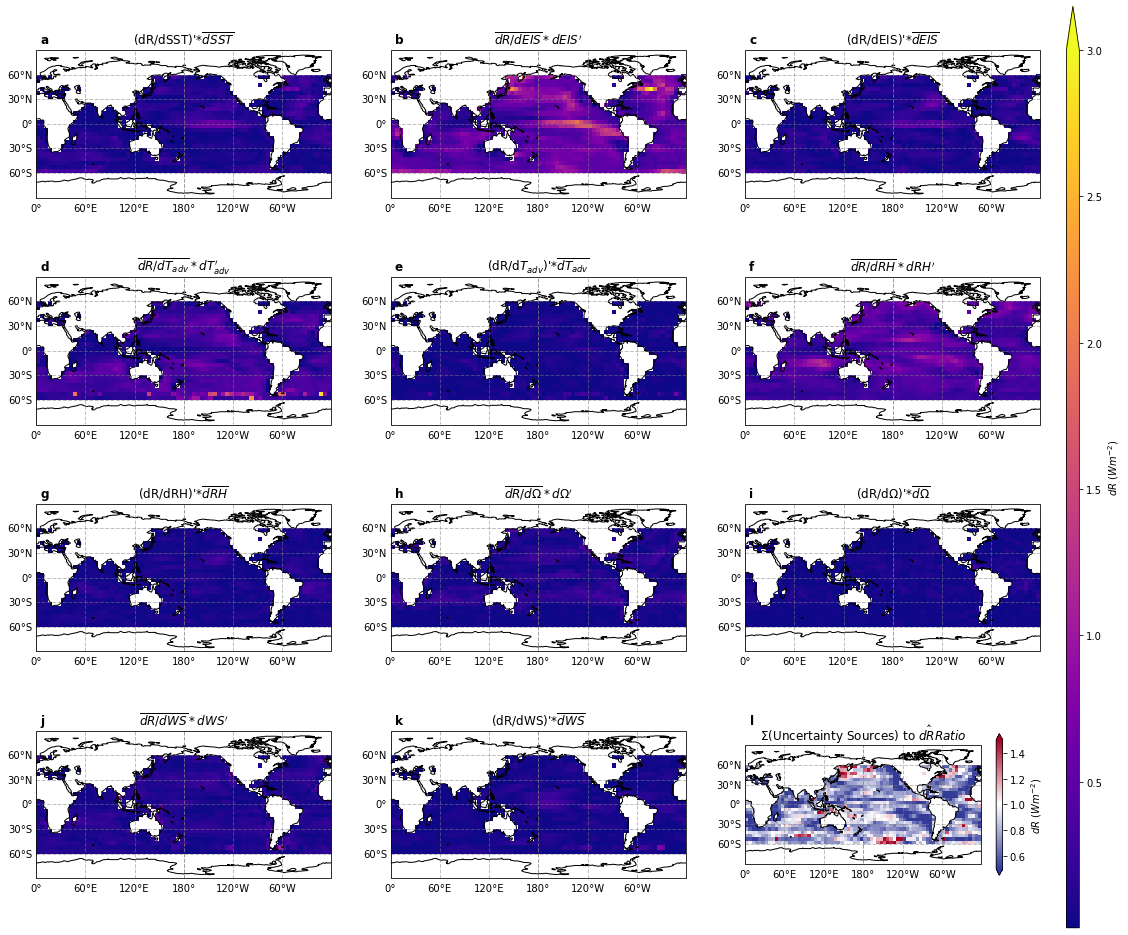

In [40]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(18,16))
ax1 = plt.subplot2grid((4,3), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((4,3), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((4,3), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((4,3), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((4,3), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((4,3), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((4,3), (2,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((4,3), (2,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax9 = plt.subplot2grid((4,3), (2,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax10 = plt.subplot2grid((4,3), (3,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax11 = plt.subplot2grid((4,3), (3,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax12 = plt.subplot2grid((4,3), (3,2), projection=ccrs.PlateCarree(central_longitude=180.0))
#fig.suptitle('Standard Deviation of Sources of Uncertainty');


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl9.xlabels_top = False
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl10.xlabels_top = False
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl11.xlabels_top = False
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl12.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines(), ax9.coastlines(),ax10.coastlines(), ax11.coastlines(), ax12.coastlines()

im = dR_model_to_sst_prime_fast_std.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',vmax=3, add_colorbar=False)
dR_intrin_eis_prime_fast_std.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_eis_prime_fast_std.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',vmax=3,add_colorbar=False)
dR_intrin_tadv_prime_fast_std.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_model_to_tadv_prime_fast_std.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_intrin_rh_prime_fast_std.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_rh_prime_fast_std.plot(ax=ax7,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_intrin_omega_prime_fast_std.plot(ax=ax8,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_omega_prime_fast_std.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_intrin_ws_prime_fast_std.plot(ax=ax10,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_model_to_ws_prime_fast_std.plot(ax=ax11,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)

colors = [cm.RdYlBu(.99), "white", cm.RdYlBu(.01) ]
nodes = [0.0, 0.5, 1.]
cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
ratio_fast_sumofterms_dR_hat.plot(ax=ax12,transform=ccrs.PlateCarree(),cmap=cmap,cbar_kwargs={'shrink': 0.75,'label':'$dR$ ($Wm^{-2}$)'},vmin=0.5, vmax=1.5,extend='both')

cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax, label='$dR$ ($Wm^{-2}$)',ticks=np.arange(0,4.2,.5),extend='max')


ax1.set_title("(dR/dSST)'*$\overline{dSST}$")
ax2.set_title("$\overline{dR/dEIS}*dEIS'$")
ax3.set_title("(dR/dEIS)'*$\overline{dEIS}$")
ax4.set_title("$\overline{dR/dT_{adv}}*dT_{adv}'$")
ax5.set_title("(dR/d$T_{adv}$)'*$\overline{dT_{adv}}$")
ax6.set_title("$\overline{dR/dRH}*dRH'$")
ax7.set_title("(dR/dRH)'*$\overline{dRH}$")
ax8.set_title("$\overline{dR/d\u03a9}*d\u03a9'$")
ax9.set_title("(dR/d\u03a9)'*$\overline{d\u03a9}$")
ax10.set_title("$\overline{dR/dWS}*dWS'$")
ax11.set_title("(dR/dWS)'*$\overline{dWS}$")
ax12.set_title('\u03A3(Uncertainty Sources) to $\hat{dR} Ratio$')

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')
make_textbox(ax9,'i')
make_textbox(ax10,'j')
make_textbox(ax11,'k')
ax12.text(0.676,0.277,'l',weight='bold',transform=fig.transFigure,fontsize=12)

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_uncertainty_fast_12maps_singcolorbar_hist_cartopy.png',  dpi=300, bbox_inches='tight')

In [36]:
# Model SST Sensitivity
dR_model_to_sst_prime_slow_std = dR_model_to_sst_prime_slow.to_array(dim='models').std('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_slow_std = dR_intrin_eis_prime_slow.to_array(dim='models').std('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_slow_std = dR_model_to_eis_prime_slow.to_array(dim='models').std('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_slow_std = dR_intrin_tadv_prime_slow.to_array(dim='models').std('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_slow_std = dR_model_to_tadv_prime_slow.to_array(dim='models').std('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_slow_std = dR_intrin_rh_prime_slow.to_array(dim='models').std('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_slow_std = dR_model_to_rh_prime_slow.to_array(dim='models').std('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_slow_std = dR_intrin_omega_prime_slow.to_array(dim='models').std('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_slow_std = dR_model_to_omega_prime_slow.to_array(dim='models').std('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_slow_std = dR_intrin_ws_prime_slow.to_array(dim='models').std('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_slow_std = dR_model_to_ws_prime_slow.to_array(dim='models').std('models')

sum_of_terms_slow = dR_model_to_sst_prime_slow+dR_intrin_eis_prime_slow+dR_model_to_eis_prime_slow+dR_intrin_tadv_prime_slow+dR_model_to_tadv_prime_slow+dR_intrin_rh_prime_slow+dR_model_to_rh_prime_slow+dR_intrin_omega_prime_slow+dR_model_to_omega_prime_slow+dR_intrin_ws_prime_slow+dR_model_to_ws_prime_slow
sum_of_terms_slow_std = sum_of_terms_slow.to_array(dim='models').std('models')
dR_hat_slow_std = dR_hat_slow.to_array(dim='models').std('models')
ratio_slow_sumofterms_dR_hat = sum_of_terms_slow_std/dR_hat_slow_std

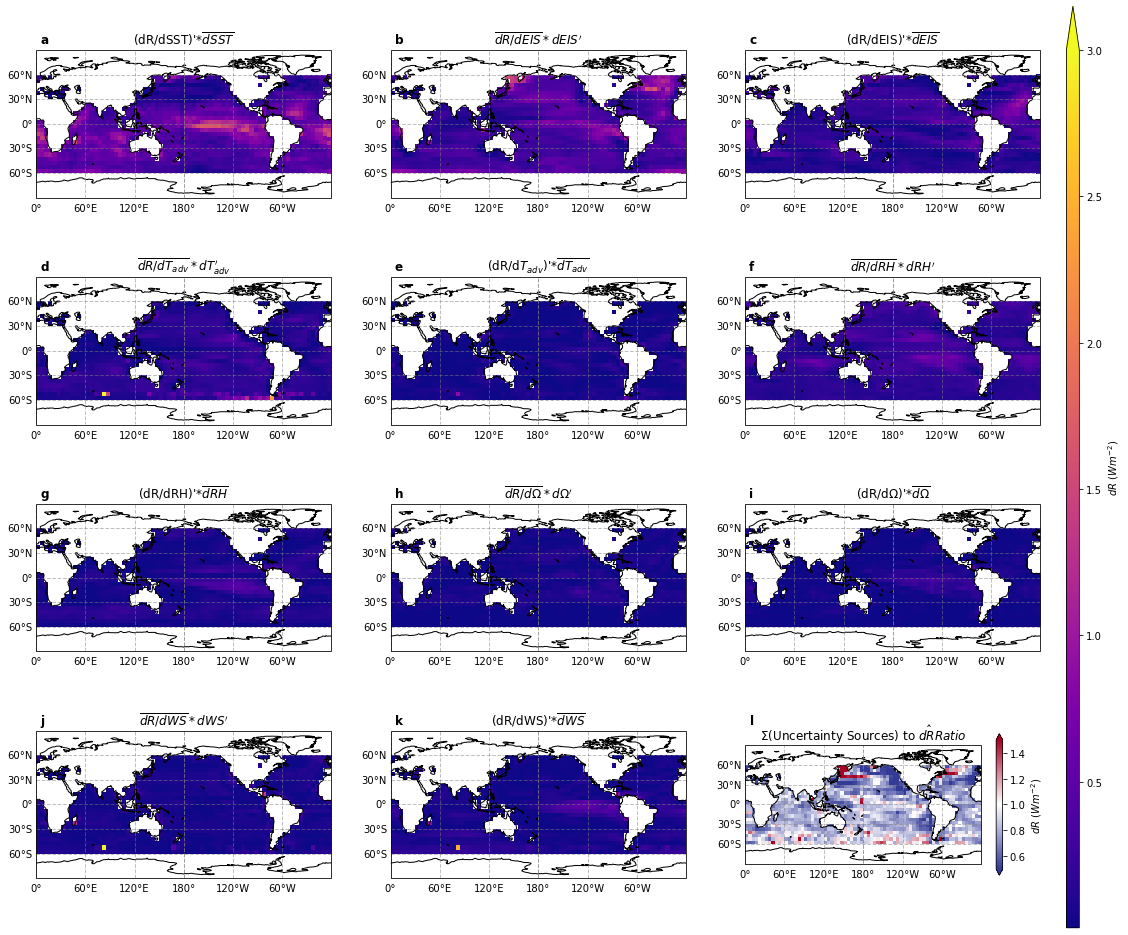

In [41]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(18,16))
ax1 = plt.subplot2grid((4,3), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((4,3), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((4,3), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((4,3), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((4,3), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((4,3), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((4,3), (2,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((4,3), (2,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax9 = plt.subplot2grid((4,3), (2,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax10 = plt.subplot2grid((4,3), (3,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax11 = plt.subplot2grid((4,3), (3,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax12 = plt.subplot2grid((4,3), (3,2), projection=ccrs.PlateCarree(central_longitude=180.0))
#fig.suptitle('Standard Deviation of Sources of Uncertainty');


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl9.xlabels_top = False
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl10.xlabels_top = False
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl11.xlabels_top = False
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl12.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines(), ax9.coastlines(),ax10.coastlines(), ax11.coastlines(), ax12.coastlines()

dR_model_to_sst_prime_slow_std.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',vmax=3, add_colorbar=False)
im = dR_intrin_eis_prime_slow_std.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_eis_prime_slow_std.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',vmax=3,add_colorbar=False)
dR_intrin_tadv_prime_slow_std.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_model_to_tadv_prime_slow_std.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_intrin_rh_prime_slow_std.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_rh_prime_slow_std.plot(ax=ax7,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_intrin_omega_prime_slow_std.plot(ax=ax8,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_model_to_omega_prime_slow_std.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)
dR_intrin_ws_prime_slow_std.plot(ax=ax10,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=3)
dR_model_to_ws_prime_slow_std.plot(ax=ax11,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=3)

colors = [cm.RdYlBu(.99), "white", cm.RdYlBu(.01) ]
nodes = [0.0, 0.5, 1.]
cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
ratio_slow_sumofterms_dR_hat.plot(ax=ax12,transform=ccrs.PlateCarree(),cmap=cmap,cbar_kwargs={'shrink': 0.75,'label':'$dR$ ($Wm^{-2}$)'},vmin=0.5, vmax=1.5,extend='both')

cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax, label='$dR$ ($Wm^{-2}$)',ticks=np.arange(0,5.2,.5),extend='max')


ax1.set_title("(dR/dSST)'*$\overline{dSST}$")
ax2.set_title("$\overline{dR/dEIS}*dEIS'$")
ax3.set_title("(dR/dEIS)'*$\overline{dEIS}$")
ax4.set_title("$\overline{dR/dT_{adv}}*dT_{adv}'$")
ax5.set_title("(dR/d$T_{adv}$)'*$\overline{dT_{adv}}$")
ax6.set_title("$\overline{dR/dRH}*dRH'$")
ax7.set_title("(dR/dRH)'*$\overline{dRH}$")
ax8.set_title("$\overline{dR/d\u03a9}*d\u03a9'$")
ax9.set_title("(dR/d\u03a9)'*$\overline{d\u03a9}$")
ax10.set_title("$\overline{dR/dWS}*dWS'$")
ax11.set_title("(dR/dWS)'*$\overline{dWS}$")
ax12.set_title('\u03A3(Uncertainty Sources) to $\hat{dR} Ratio$')

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')
make_textbox(ax9,'i')
make_textbox(ax10,'j')
make_textbox(ax11,'k')
ax12.text(0.676,0.277,'l',weight='bold',transform=fig.transFigure,fontsize=12)

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_uncertainty_slow_12maps_singcolorbar_hist_cartopy.png',  dpi=300, bbox_inches='tight')